In [2]:
%matplotlib inline
# from ExKMC.Tree import Tree # import from cloned local library followed by installing manually
import sys
sys.path.append('../')
from ExKMC_M.ExKMC.Tree import Tree

import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, normalize
from utils import plot_confusion_matrix,silhouette_score,f_a_score
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from IPython.display import Image

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN
from collections import Counter

import seaborn as sns

from evaluation import getMojofm,get_similarity,plot_count
from dataPre import fs_FRUFS
from multi_imbalance.resampling.soup import SOUP
from multi_imbalance.resampling.global_cs import GlobalCS
from multi_imbalance.resampling.mdo import MDO

## Data preprocessing

In [3]:
# input data
DF = pd.read_csv('/home/sfy/Documents/VScodeProject/Thesis/data/family.csv',index_col=False)
print(f'Data shape is {DF.shape}')

grouped = DF.groupby(['family'])
# get numbers of each group 
groupCount = grouped['family'].count()
table_count = groupCount.sort_values(ascending=False)[:20]
print(table_count)
# select by numbers of the top 
TOP = 11

selected = groupCount.sort_values(ascending=False)[1:TOP]
# plot_count(selected)

# get names
selectedNames = list(selected.index)
print(f"selected family are {selectedNames}")

# select trained
train = DF.loc[DF["family"].isin(selectedNames)]
train.reset_index(inplace=True, drop=True)
print(f"train dataset shape {train.shape}")


# encode into encoder
le = LabelEncoder()
label = le.fit_transform(train["family"])
# print(train.head(5))

# exclue name -> X_
train = train.loc[:, train.columns != "name"]
train = train.loc[:, train.columns != "family"]

# remove duplicates -> X
# parameter with first and last ? !!!! can be discussed
# X = train.drop_duplicates(keep='last')
X = train

# with X.index canbe reserved to original labels
Y = np.take(label, X.index)

print(f"Without duplications wi shape {X.shape}")
print(f"With duplications wi shape {train.shape}")

X.reset_index(inplace=True, drop=True)

# X.head(5)
# X.to_csv('testDup.csv',index=False)

Data shape is (20760, 698)
family
Airpush         6652
FakeInst        2168
Mecor           1820
Youmi           1300
Fusob           1262
Kuguo           1197
Dowgin           862
BankBot          647
Jisut            558
DroidKungFu      546
RuMMS            402
Lotoor           329
Mseg             235
Boqx             215
Minimob          203
Triada           197
Kyview           175
SlemBunk         174
SimpleLocker     172
SmsKey           165
Name: family, dtype: int64
selected family are ['FakeInst', 'Mecor', 'Youmi', 'Fusob', 'Kuguo', 'Dowgin', 'BankBot', 'Jisut', 'DroidKungFu', 'RuMMS']
train dataset shape (10762, 698)
Without duplications wi shape (10762, 696)
With duplications wi shape (10762, 696)


## Train -kmeans

[(0, 402), (1, 402), (2, 402), (3, 402), (4, 402), (5, 402), (6, 402), (7, 402), (8, 402), (9, 402)]


Progress bar: 100%|██████████| 696/696 [00:19<00:00, 35.25it/s] 


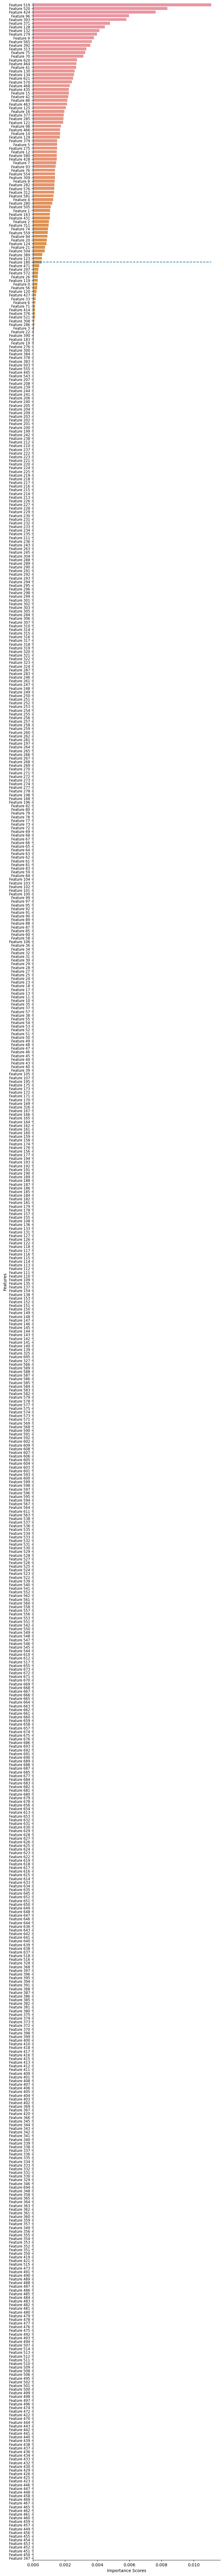

--Result of cluster 0 the largest is Fusob with 0.9975186104218362
--Result of cluster 1 the largest is Kuguo with 0.3382997370727432
--Result of cluster 2 the largest is Jisut with 0.8112745098039216
--Result of cluster 3 the largest is RuMMS with 0.2915129151291513
--Result of cluster 4 the largest is BankBot with 0.32338308457711445
--Result of cluster 5 the largest is DroidKungFu with 0.7227722772277227
--Result of cluster 6 the largest is RuMMS with 0.44525547445255476
--Result of cluster 7 the largest is FakeInst with 0.6700680272108843
--Result of cluster 8 the largest is Mecor with 1.0
--Result of cluster 9 the largest is DroidKungFu with 0.1517412935323383
{'Dowgin', 'Youmi'}


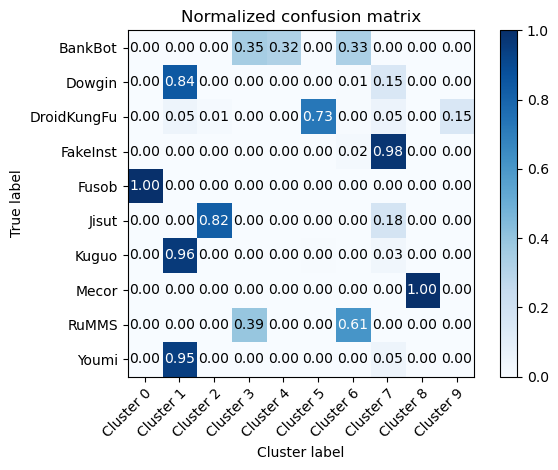

82.24


In [4]:
# from sklearn.feature_selection import VarianceThreshold,GenericUnivariateSelect,chi2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=0)

K = len(selectedNames)
X_train = X
X_train.shape

# success with variance
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train)

# imbalanced data

# smote_enn = SMOTEENN(random_state=0)

# X_resampled, y_resampled = smote_enn.fit_resample(X, Y)
# print(sorted(Counter(y_resampled).items()))
############
clf = NearMiss(version=1)
# clf = SMOTEENN(random_state=42)

# clf = GlobalCS()

resampled_X, resampled_y = clf.fit_resample(scaled_df, Y)
# resampled_X, resampled_y = nm1.fit_resample(X, Y)


print(sorted(Counter(resampled_y).items()))
# checek resampeld data count


# Converting the numpy array into a pandas DataFrame
X_train_ = pd.DataFrame(resampled_X)

# feature selection
X_train_prued = fs_FRUFS(X_train_,k=0.1)

# 
###training --------------------------------------
#models
kmeans = KMeans(K,random_state=0)
kmeans.fit(X_train_prued)


# f_a_score(Y, kmeans_labels, tree_labels=tree_labels)
kmeans.inertia_
get_similarity(y_true = resampled_y,y_predict = kmeans.labels_,le = le,wholeList= selectedNames )


class_names = np.array(list(le.inverse_transform([_ for _ in range(TOP-1)])))
plot_confusion_matrix(resampled_y,kmeans.labels_,class_names,normalize=True)
plt.savefig("confusion_mat")
plt.show()

### MoJofm for result

getMojofm(index_X=X_train_prued.index,predict=kmeans.labels_,y_true=resampled_y)


In [27]:
# X_train_prued + resampled_y output for other algorithm
dataset = pd.DataFrame(resampled_X,columns=list(train.columns.values))
dataset['label'] = list(resampled_y)
dataset.to_csv('dataset_R')


In [26]:
dataset

,android.permission.CAMERA,android.permission.READ_CONTACTS,android.permission.WRITE_CONTACTS,android.permission.GET_ACCOUNTS,android.permission.ACCESS_FINE_LOCATION,android.permission.ACCESS_COARSE_LOCATION,android.permission.RECORD_AUDIO,android.permission.READ_PHONE_STATE,android.permission.CALL_PHONE,android.permission.READ_CALL_LOG,...,org/apache/harmony/crypto/internal/NullCipherSpi;engineInit,org/apache/harmony/crypto/internal/NullCipherSpi;engineUpdate,org/apache/harmony/crypto/internal/NullCipherSpi;engineGetIV,org/apache/harmony/crypto/internal/NullCipherSpi;engineDoFinal,org/apache/harmony/crypto/internal/NullCipherSpi;engineSetMode,org/apache/harmony/crypto/internal/NullCipherSpi;engineSetPadding,org/apache/harmony/crypto/internal/NullCipherSpi;engineGetBlockSize,org/apache/harmony/crypto/internal/NullCipherSpi;engineWrap,Unnamed: 696,label
0,-0.436297,1.793163,-0.4029,-0.552948,-1.035763,-1.155421,-0.200772,0.23495,1.348338,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.436297,1.793163,-0.4029,-0.552948,-1.035763,-1.155421,-0.200772,0.23495,1.348338,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.436297,1.793163,-0.4029,-0.552948,-1.035763,-1.155421,-0.200772,0.23495,1.348338,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.436297,1.793163,-0.4029,-0.552948,-1.035763,-1.155421,-0.200772,0.23495,1.348338,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.436297,1.793163,-0.4029,-0.552948,-1.035763,-1.155421,-0.200772,0.23495,1.348338,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,-0.436297,-0.557674,-0.4029,-0.552948,-1.035763,0.865486,-0.200772,0.23495,-0.741654,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4016,-0.436297,-0.557674,-0.4029,-0.552948,-1.035763,-1.155421,-0.200772,0.23495,-0.741654,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4017,-0.436297,-0.557674,-0.4029,-0.552948,-1.035763,0.865486,-0.200772,0.23495,-0.741654,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4018,-0.436297,-0.557674,-0.4029,-0.552948,0.965472,0.865486,-0.200772,0.23495,-0.741654,-0.37293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


## Evaluation

### Jaccard for label

In [6]:
# list(le.inverse_transform([0,3,4,7,9]))

list(le.inverse_transform([_ for _ in range(10)]))


['BankBot',
 'Dowgin',
 'DroidKungFu',
 'FakeInst',
 'Fusob',
 'Jisut',
 'Kuguo',
 'Mecor',
 'RuMMS',
 'Youmi']

### distance

In [7]:
#test with distancs munally
# inter-distance
from scipy.spatial.distance import euclidean

dst = euclidean(kmeans.cluster_centers_[0], kmeans.cluster_centers_[1])
print(f"inter distance from kmeans:{dst}")

tree_centers = tree.get_centers()
tree_dst = euclidean(tree_centers[0], tree_centers[1])
print(f"inter distance from tree:{tree_dst}")

print(f'intra and inter distance of kmenas is {silhouette_score(X=X_train_, labels=Y)}')
# print(f'intra and inter distance of tree score is {silhouette_score(X=X_train, labels=tree_labels)}')


inter distance from kmeans:6.697078639444019


NameError: name 'tree' is not defined

## XAI-Exkmc

In [ ]:
# train Exkmc
leaves_option = 2
tree = Tree(k=K,max_leaves=leaves_option * K)
tree_labels = tree.fit_predict(X_train_prued, kmeans)

feature_names = list(train.columns.values)

tree.plot(filename=f'test{leaves_option}_imbalanced',feature_names=feature_names)



(eog:27403): Gtk-WARNING **: 13:35:19.994: Could not load a pixbuf from icon theme.
This may indicate that pixbuf loaders or the mime database could not be found.


In [ ]:
# cost
# kmeas cost in paper: The k-means cost is the sum of squared distances of each point to the mean of points associated with the cluster.
# kmenas cost in sklearn:Opposite of the value of X on the K-means objective.
# surrogate cost:The k-means surrogate cost is the sum of squared distances of each point to the closest center of the kmeans given (or trained) in the fit method.k-means surrogate cost > k-means cost, as k-means cost is computed with respect to the optimal centers.

def get_surr_cost_ratio(tree,train):

    kmeas_cost = tree.score(train)
    surrogate_score = tree.surrogate_score(train)
    #print(f"kmeans_cost is {kmeas_cost} \nsurrogate_score is {surrogate_score}\nkmenas cost in surrogate is {kmeans.score(train)}")
    ratio = surrogate_score / kmeas_cost
    print(f"Cost ratio : {ratio}")

# display with multiple options of leaves from 2 3 4
for i in range(1,6):
    tree = Tree(k=K,max_leaves=i * K)
    tree.fit_predict(X_train_, kmeans)
    print(f"I----{i}")
    get_surr_cost_ratio(tree,X_train_)
    # tree.plot(filename=f'test{i}')
    # Image(filename=f'test{i}.gv.png') 